Aligning raster2 to raster1's grid with one-cell shift left...
Grid information before alignment:
Raster 1 (Reference) Information:
Width: 17834, Height: 18454
Bounds: BoundingBox(left=1811757.8173831038, bottom=3664715.6978284796, right=2349640.4150661896, top=4221297.813878926)
Resolution: (30.160513495743295, 30.160513495743295)
CRS: EPSG:3460
Transform: 
| 30.16, 0.00, 1811757.82|
| 0.00,-30.16, 4221297.81|
| 0.00, 0.00, 1.00|
--------------------------------------------------
Raster 2 (To be aligned) Information:
Width: 17838, Height: 18457
Bounds: BoundingBox(left=1811757.8173831038, bottom=3664727.8948090365, right=2349661.8221680652, top=4221297.813875974)
Resolution: (30.154950374759583, 30.154950374759583)
CRS: EPSG:3460
Transform: 
| 30.15, 0.00, 1811757.82|
| 0.00,-30.15, 4221297.81|
| 0.00, 0.00, 1.00|
--------------------------------------------------


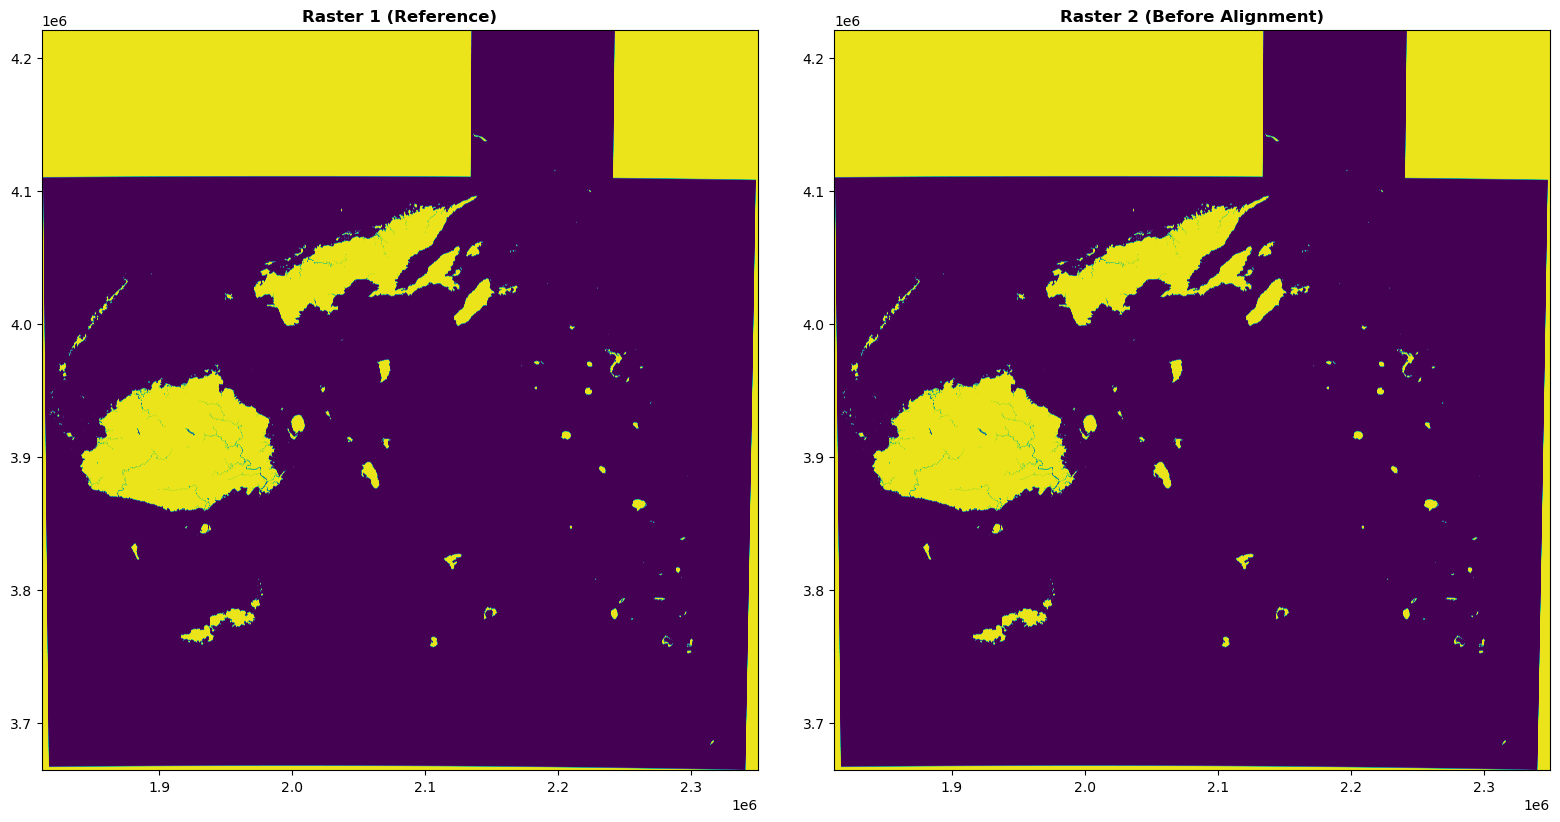

Aligning raster2 to raster1's grid...
Aligned raster saved to: X:/Work/WB/Risk_tools/script/data/HZD/FJI/PLUVIAL_DEFENDED/2050/SSP5_8.5/1in10_fix.tif

Grid information after alignment:
Raster 1 (Reference) Information:
Width: 17834, Height: 18454
Bounds: BoundingBox(left=1811757.8173831038, bottom=3664715.6978284796, right=2349640.4150661896, top=4221297.813878926)
Resolution: (30.160513495743295, 30.160513495743295)
CRS: EPSG:3460
Transform: 
| 30.16, 0.00, 1811757.82|
| 0.00,-30.16, 4221297.81|
| 0.00, 0.00, 1.00|
--------------------------------------------------
Raster 2 (After Alignment) Information:
Width: 17834, Height: 18454
Bounds: BoundingBox(left=1811727.656869608, bottom=3664715.6978284796, right=2349610.254552694, top=4221297.813878926)
Resolution: (30.160513495743295, 30.160513495743295)
CRS: EPSG:3460
Transform: 
| 30.16, 0.00, 1811727.66|
| 0.00,-30.16, 4221297.81|
| 0.00, 0.00, 1.00|
--------------------------------------------------


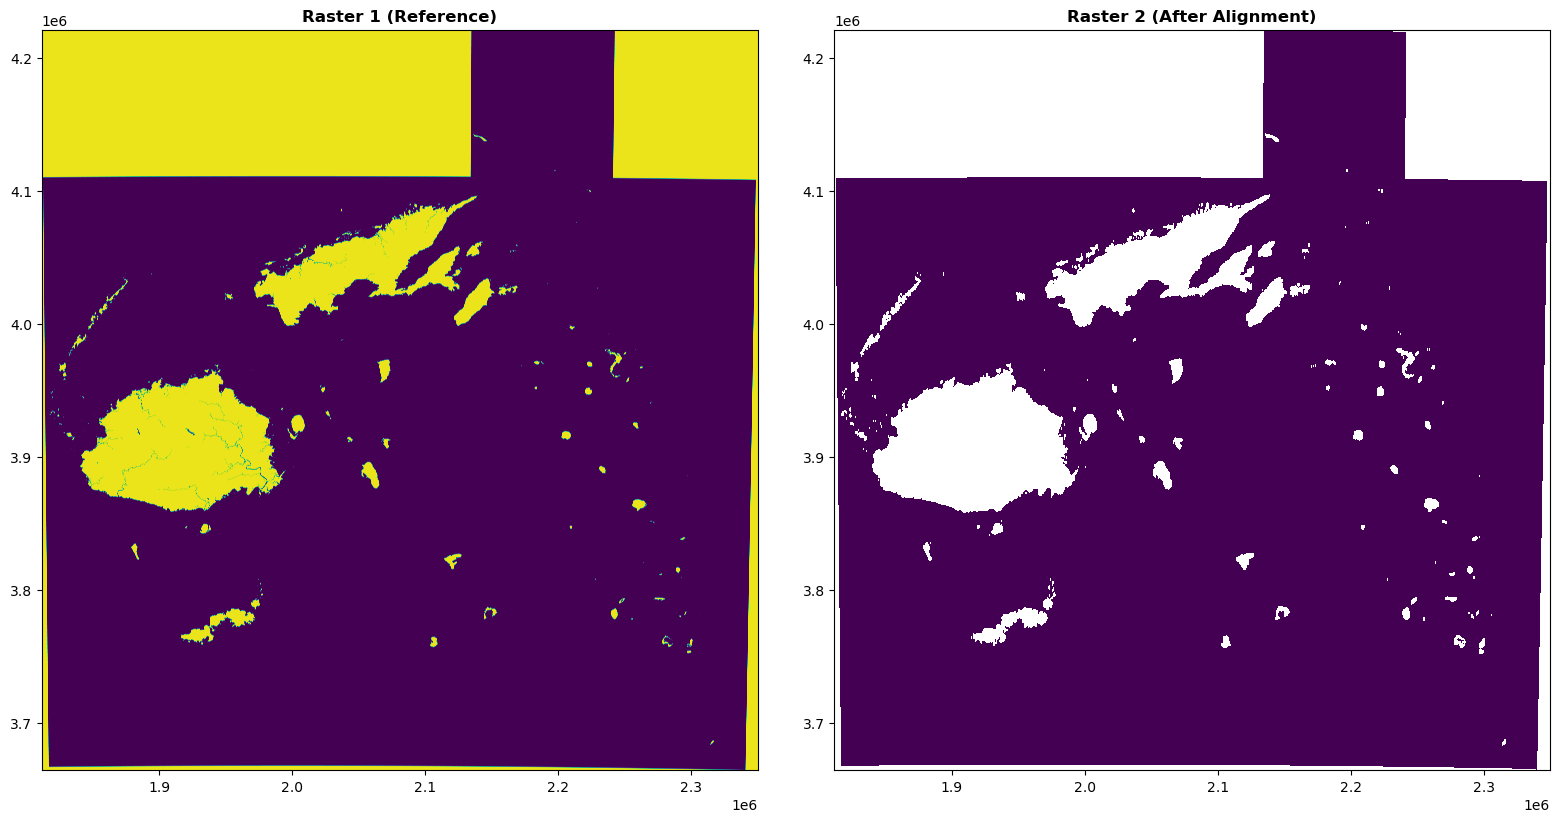

In [7]:
# Raster Grid Alignment
# This notebook aligns raster 2 to the same grid as raster 1

import rasterio
from rasterio.warp import calculate_default_transform, reproject
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import os

# Function to visualize rasters side by side for comparison
def plot_rasters(raster1_path, raster2_path, title1='Raster 1', title2='Raster 2'):
    """
    Plot two rasters side by side for visual comparison
    
    Parameters:
    -----------
    raster1_path: str
        Path to the first raster file
    raster2_path: str
        Path to the second raster file
    title1: str
        Title for the first raster
    title2: str
        Title for the second raster
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    with rasterio.open(raster1_path) as src1:
        show(src1, ax=ax1, title=title1)
    
    with rasterio.open(raster2_path) as src2:
        show(src2, ax=ax2, title=title2)
    
    plt.tight_layout()
    plt.show()

# Function to display grid alignment information
def print_grid_info(raster_path, name="Raster"):
    """
    Print grid information for a raster
    
    Parameters:
    -----------
    raster_path: str
        Path to the raster file
    name: str
        Name to display for the raster
    """
    with rasterio.open(raster_path) as src:
        print(f"{name} Information:")
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"Bounds: {src.bounds}")
        print(f"Resolution: {src.res}")
        print(f"CRS: {src.crs}")
        print(f"Transform: \n{src.transform}")
        print("-" * 50)

# Function to align raster2 to raster1's grid
def align_raster_grids(raster1_path, raster2_path, output_path):
    """
    Align raster2 to the same grid as raster1
    
    Parameters:
    -----------
    raster1_path: str
        Path to the reference raster file
    raster2_path: str
        Path to the raster file that needs to be aligned
    output_path: str
        Path where the aligned raster will be saved
    
    Returns:
    --------
    str
        Path to the aligned raster
    """
    # Read the reference raster (raster1)
    with rasterio.open(raster1_path) as src1:
        # Get the metadata from raster1
        dst_crs = src1.crs
        dst_transform = src1.transform
        dst_height = src1.height
        dst_width = src1.width
        
        # Set up the output metadata
        dst_kwargs = src1.meta.copy()
        
        # Read raster2
        with rasterio.open(raster2_path) as src2:
            # Check if CRS is different and needs to be reprojected
            src2_crs = src2.crs
            
            # Prepare for reprojection and alignment
            # Calculate the optimal transform if CRS differs
            if src2_crs != dst_crs:
                transform, width, height = calculate_default_transform(
                    src2.crs, dst_crs, src2.width, src2.height, 
                    *src2.bounds, resolution=src1.res
                )
            else:
                transform = dst_transform
                width = dst_width
                height = dst_height
            
            # Create a shifted transform (one cell to the left)
            shifted_transform = rasterio.Affine(
                dst_transform.a,
                dst_transform.b,
                dst_transform.c - dst_transform.a,  # Shift one cell to the left
                dst_transform.d,
                dst_transform.e,
                dst_transform.f
            )
            
            # Update metadata with shifted transform and compression
            dst_kwargs.update({
                'crs': dst_crs,
                'transform': shifted_transform,
                'width': dst_width,
                'height': dst_height,
                'nodata': src2.nodata if src2.nodata is not None else 0,
                'compress': 'deflate',
                'predictor': 2  # Horizontal differencing predictor for better compression
            })
            
            # Make sure the data type is preserved from raster2
            dst_kwargs['dtype'] = src2.dtypes[0]
            
            # Create the output file
            with rasterio.open(output_path, 'w', **dst_kwargs) as dst:
                # Read each band from raster2 and reproject to raster1's grid
                for i in range(1, src2.count + 1):
                    reproject(
                        source=rasterio.band(src2, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src2.transform,
                        src_crs=src2.crs,
                        dst_transform=shifted_transform,  # Use the shifted transform
                        dst_crs=dst_crs,
                        resampling=rasterio.warp.Resampling.nearest
                    )
    
    return output_path

# Main code execution
if __name__ == "__main__":
    # Replace these with your actual file paths
    raster1_path = "X:/Work/WB/Risk_tools/script/data/HZD/FJI/PLUVIAL_DEFENDED/2050/SSP2_4.5/1in10.tif"  # Reference raster
    raster2_path = "X:/Work/WB/Risk_tools/script/data/HZD/FJI/PLUVIAL_DEFENDED/2050/SSP5_8.5/1in10.tif"  # Raster to be aligned
    aligned_output_path = "X:/Work/WB/Risk_tools/script/data/HZD/FJI/PLUVIAL_DEFENDED/2050/SSP5_8.5/1in10_fix.tif"
    
    # Choose one of the following methods:
    
    # Method 1: Full alignment with one-cell shift left (recommended)
    print("Aligning raster2 to raster1's grid with one-cell shift left...")
    aligned_raster_path = align_raster_grids(raster1_path, raster2_path, aligned_output_path)
    
    # Method 2: Full alignment with one-cell shift left and custom resampling
    # print("Aligning raster2 to raster1's grid with one-cell shift left and bilinear resampling...")
    # aligned_raster_path = align_raster_grids_with_resampling(
    #     raster1_path, raster2_path, aligned_output_path, resampling_method='bilinear'
    # )
    
    # Method 3: Simple shift without reprojection (only works if rasters already share same CRS and resolution)
    # print("Only shifting raster2 by one cell to the left without reprojection...")
    # First align without shift
    # temp_aligned_path = "path/to/temp_aligned.tif"
    # align_raster_grids_with_resampling(raster1_path, raster2_path, temp_aligned_path)
    # Then apply the shift
    # aligned_raster_path = shift_raster_one_cell_left(temp_aligned_path, aligned_output_path)
    # Optional: remove temporary file
    # import os
    # os.remove(temp_aligned_path)
    
    # Print grid information before alignment
    print("Grid information before alignment:")
    print_grid_info(raster1_path, "Raster 1 (Reference)")
    print_grid_info(raster2_path, "Raster 2 (To be aligned)")
    
    # Plot rasters before alignment
    plot_rasters(raster1_path, raster2_path, 
                 title1="Raster 1 (Reference)", 
                 title2="Raster 2 (Before Alignment)")
    
    # Align raster2 to raster1's grid
    print("Aligning raster2 to raster1's grid...")
    aligned_raster_path = align_raster_grids(raster1_path, raster2_path, aligned_output_path)
    print(f"Aligned raster saved to: {aligned_raster_path}")
    
    # Print grid information after alignment
    print("\nGrid information after alignment:")
    print_grid_info(raster1_path, "Raster 1 (Reference)")
    print_grid_info(aligned_output_path, "Raster 2 (After Alignment)")
    
    # Plot rasters after alignment
    plot_rasters(raster1_path, aligned_output_path, 
                 title1="Raster 1 (Reference)", 
                 title2="Raster 2 (After Alignment)")

# Additional functions that might be useful

# Function to manually shift the raster by one cell to the left
def shift_raster_one_cell_left(input_raster_path, output_raster_path):
    """
    Manually shift a raster by one cell to the left
    
    Parameters:
    -----------
    input_raster_path: str
        Path to the input raster file
    output_raster_path: str
        Path where the shifted raster will be saved
    
    Returns:
    --------
    str
        Path to the shifted raster
    """
    with rasterio.open(input_raster_path) as src:
        # Get the metadata
        meta = src.meta.copy()
        
        # Calculate shifted transform (one cell to the left)
        shifted_transform = rasterio.Affine(
            src.transform.a,            # Same cell width
            src.transform.b,            # Same rotation term
            src.transform.c - src.transform.a,  # Shift one cell to the left
            src.transform.d,            # Same rotation term
            src.transform.e,            # Same cell height
            src.transform.f             # Same north edge
        )
        
        # Update metadata with shifted transform and compression
        meta.update({
            'transform': shifted_transform,
            'compress': 'deflate',
            'predictor': 2
        })
        
        # Create output file with the shifted transform
        with rasterio.open(output_raster_path, 'w', **meta) as dst:
            # Simply write the data without reprojection
            # This ensures a pure shift without resampling
            for i in range(1, src.count + 1):
                dst.write(src.read(i), i)
    
    return output_raster_path

# Function to check if two rasters are aligned
def check_alignment(raster1_path, raster2_path):
    """
    Check if two rasters are aligned on the same grid
    
    Parameters:
    -----------
    raster1_path: str
        Path to the first raster file
    raster2_path: str
        Path to the second raster file
    
    Returns:
    --------
    bool
        True if rasters are aligned, False otherwise
    dict
        Dictionary with details about alignment issues
    """
    issues = {}
    with rasterio.open(raster1_path) as src1:
        with rasterio.open(raster2_path) as src2:
            # Check CRS
            if src1.crs != src2.crs:
                issues['crs'] = {
                    'raster1': src1.crs,
                    'raster2': src2.crs
                }
            
            # Check pixel resolution
            if src1.res != src2.res:
                issues['resolution'] = {
                    'raster1': src1.res,
                    'raster2': src2.res
                }
            
            # Check alignment of origins
            origin1 = (src1.transform.c, src1.transform.f)
            origin2 = (src2.transform.c, src2.transform.f)
            
            # Calculate offset in terms of pixels
            x_offset = abs((origin1[0] - origin2[0]) / src1.res[0])
            y_offset = abs((origin1[1] - origin2[1]) / src1.res[1])
            
            # Check if the offset is significant (more than a small fraction of a pixel)
            if x_offset > 0.01 or y_offset > 0.01:
                issues['origin'] = {
                    'raster1': origin1,
                    'raster2': origin2,
                    'x_offset_pixels': x_offset,
                    'y_offset_pixels': y_offset
                }
    
    return len(issues) == 0, issues

# Function to change resampling method if needed
def align_raster_grids_with_resampling(raster1_path, raster2_path, output_path, resampling_method='nearest'):
    """
    Align raster2 to the same grid as raster1 with specified resampling method,
    with a one-cell shift to the left
    
    Parameters:
    -----------
    raster1_path: str
        Path to the reference raster file
    raster2_path: str
        Path to the raster file that needs to be aligned
    output_path: str
        Path where the aligned raster will be saved
    resampling_method: str
        Resampling method to use. Options: 'nearest', 'bilinear', 'cubic', 'cubic_spline',
        'lanczos', 'average', 'mode', 'max', 'min', 'med', 'q1', 'q3'
    
    Returns:
    --------
    str
        Path to the aligned raster
    """
    # Map string resampling method to rasterio.warp.Resampling enum
    resampling_methods = {
        'nearest': rasterio.warp.Resampling.nearest,
        'bilinear': rasterio.warp.Resampling.bilinear,
        'cubic': rasterio.warp.Resampling.cubic,
        'cubic_spline': rasterio.warp.Resampling.cubic_spline,
        'lanczos': rasterio.warp.Resampling.lanczos,
        'average': rasterio.warp.Resampling.average,
        'mode': rasterio.warp.Resampling.mode,
        'max': rasterio.warp.Resampling.max,
        'min': rasterio.warp.Resampling.min,
        'med': rasterio.warp.Resampling.med,
        'q1': rasterio.warp.Resampling.q1,
        'q3': rasterio.warp.Resampling.q3
    }
    
    # Select the resampling method
    resampling = resampling_methods.get(resampling_method.lower(), rasterio.warp.Resampling.nearest)
    
    # Read the reference raster (raster1)
    with rasterio.open(raster1_path) as src1:
        # Get the metadata from raster1
        dst_crs = src1.crs
        dst_transform = src1.transform
        dst_height = src1.height
        dst_width = src1.width
        
        # Calculate shifted transform (one cell to the left)
        shifted_transform = rasterio.Affine(
            dst_transform.a,            # Same cell width
            dst_transform.b,            # Same rotation term
            dst_transform.c - dst_transform.a,  # Shift one cell to the left
            dst_transform.d,            # Same rotation term
            dst_transform.e,            # Same cell height
            dst_transform.f             # Same north edge
        )
        
        # Set up the output metadata
        dst_kwargs = src1.meta.copy()
        
        # Read raster2
        with rasterio.open(raster2_path) as src2:
            # Update metadata with compression and source raster2's data type
            dst_kwargs.update({
                'crs': dst_crs,
                'transform': shifted_transform,  # Use the shifted transform
                'width': dst_width,
                'height': dst_height,
                'nodata': src2.nodata if src2.nodata is not None else 0,
                'dtype': src2.dtypes[0],
                'compress': 'deflate',
                'predictor': 2  # Horizontal differencing predictor for better compression
            })
            
            # Create the output file with the shifted transform
            with rasterio.open(output_path, 'w', **dst_kwargs) as dst:
                # Create a temporary in-memory array to hold the resampled data
                temp_data = np.zeros((src2.count, dst_height, dst_width), dtype=src2.dtypes[0])
                
                # First resample to the original grid (without shift)
                for i in range(1, src2.count + 1):
                    reproject(
                        source=rasterio.band(src2, i),
                        destination=temp_data[i-1],
                        src_transform=src2.transform,
                        src_crs=src2.crs,
                        dst_transform=dst_transform,  # Use original transform for resampling
                        dst_crs=dst_crs,
                        dst_shape=(dst_height, dst_width),
                        resampling=resampling
                    )
                
                # Write the data to the output file (which has the shifted transform)
                for i in range(1, src2.count + 1):
                    dst.write(temp_data[i-1], i)
    
    return output_path

# Example usage with different resampling method:
# aligned_raster_path = align_raster_grids_with_resampling(
#     raster1_path, raster2_path, aligned_output_path, resampling_method='bilinear'
# )